In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('..'))

from autocnet.examples import get_path
from autocnet.graph.network import CandidateGraph
from autocnet.graph.edge import Edge
from autocnet.matcher.matcher import FlannMatcher

from autocnet.matcher import subpixel as sp 
from scipy.misc import imresize
import math
import warnings
import cv2

from bisect import bisect_left

from scipy.ndimage.interpolation import rotate

from IPython.display import display
warnings.filterwarnings('ignore')

%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Create Basic Structures

In [2]:
#Point to the adjacency Graph
adjacency = get_path('three_image_adjacency.json')
basepath = get_path('Apollo15')
cg = CandidateGraph.from_adjacency(adjacency, basepath=basepath)

#Apply SIFT to extract features
cg.extract_features(method='sift', extractor_parameters={'nfeatures':500})

#Match
cg.match_features()

# Perform the symmetry check
cg.symmetry_checks()
# Perform the ratio check
cg.ratio_checks(clean_keys = ['symmetry'])
# Create fundamental matrix
cg.compute_fundamental_matrices(clean_keys = ['symmetry', 'ratio'])


# Step: Compute the homographies and apply RANSAC
cg.compute_homographies(clean_keys=['symmetry', 'ratio'])

# Step: Compute the overlap ratio and coverage ratio
for s, d, edge in cg.edges_iter(data=True):
    edge.coverage_ratio(clean_keys=['symmetry', 'ratio'])

# Step: Compute subpixel offsets for candidate points
cg.subpixel_register(clean_keys=['ransac'])

cg.suppress(clean_keys=['symmetry', 'ratio', 'subpixel'])

# Define Stuff

In [170]:
from copy import deepcopy


def cartesian_product(arrays, out=None):
    """
    Generate a cartesian product of input arrays.

    Parameters
    ----------
    arrays : list of array-like
        1-D arrays to form the cartesian product of.
    out : ndarray
        Array to place the cartesian product in.

    Returns
    -------
    out : ndarray
        2-D array of shape (M, len(arrays)) containing cartesian products
        formed of input arrays.
    """

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    m = n / arrays[0].size
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian_product(arrays[1:], out=out[0:m,1:])
        for j in range(1, arrays[0].size):
            out[j*m:(j+1)*m,1:] = out[0:m,1:]
    return out

def corr_normed(template, search):
    if(len(template) < len(search)):
        search = search[:len(template)]
    elif(len(template) > len(search)):
        template = template[:len(search)]
    
    # get averages
    template_avg = np.average(template)
    search_avg = np.average(search)
    
    # compute mean-corrected vetcors
    mc_template = [x-template_avg for x in template]
    mc_search = [x-search_avg for x in search]
    
    # Perform element-wise multiplication 
    arr1xarr2 = np.multiply(mc_template, mc_search)
    
    # element-wise divide by the mangitude1 x magnitude2
    # and return the result
    std1xstd2 = numpy.std(template) * numpy.std(search)
    
    coeffs = [(x/std1xstd2) for x in arr1xarr2]
    return np.average(coeffs)
    
    
def to_polar_coord(shape, center):
    y,x = np.ogrid[:shape[0],:shape[1]]
    cy,cx = center
    tmin,tmax = (0,2*math.pi)

    # ensure stop angle > start angle
    if tmax < tmin:
        tmax += 2*np.pi

    # convert cartesian --> polar coordinates
    r2 = (x-cx)*(x-cx) + (y-cy)*(y-cy)
    theta = np.arctan2(x-cx,y-cy) - tmin

    # wrap angles between 0 and 2*pi
    theta %= (2*np.pi)
    
    return r2, theta


def circ_mask(shape,center,radius):
    r, theta = to_polar_coord(shape, center)
    
    circmask = r == radius*radius
    anglemask = theta <= 2*math.pi
        
    return circmask*anglemask


def radial_line_mask(shape, center, radius, alpha=0.19460421, atol=.01):
    r, theta = to_polar_coord(shape, center)
    
    line_mask = r <= radius**2
    anglemask = numpy.isclose(theta, alpha, atol=atol)
        
    return line_mask*anglemask
    
    
def ciratefi(template, search_image, upsampling=1, cifi_thresh=.7, rafi_thresh=.7, tefi_thresh=1.0, 
             use_percentile=False, alpha=math.pi/16, 
             scales=[0.5, 0.57, 0.66,  0.76, 0.87, 1.0], radii=list(range(1,12))):
    '''
        Run the cirateft algorithm given the input template and target image along
        with scales and Radii. 
    '''
    # check the paramter domains
    if upsampling < 1:
        raise ValueError('Upsampling must be >= 1')
    
    if template.shape > search_image.shape:
        raise ValueError('Template Image is smaller than Search Image for template of size: {} and search image of size: {}'\
                          .format(template.shape, search_image.shape))
        
    # check for upsampling
    # if upsampling > 1:
    #    template = zoom(template, upsampling, order=3)
    #    search_image = zoom(search_image, upsampling, order=3)
    
    # Cifi -- Circular Sample on Template
    template_result = np.empty((len(scales), len(radii)))
    
    for i, s in enumerate(scales):
        scaled_img = imresize(template, s)
        for j, r in enumerate(radii):
            # Generate a circular mask
            a, b = (int(scaled_img.shape[0] / 2),
                    int(scaled_img.shape[1] / 2))
            
            if r > b or r > a:
                s =-1
            
            mask = circ_mask(scaled_img.shape, (a,b), r)
            
            inv_area = 1 / (2 * math.pi * r)
            s = math.floor(np.sum(scaled_img[mask]) * inv_area)
            
            if s == 0 or r>scaled_img.shape[0] or r>scaled_img.shape[1]:
                s = -math.inf
            template_result[i,j] = s
    
    # Cifi2 -- Circular Sample on Target Image
    search_result = np.empty((search_image.shape[0], search_image.shape[1], len(radii)))
    
    for i, y in enumerate(range(search_image.shape[0])):
        for j, x in enumerate(range(search_image.shape[1])):
            for k, r in enumerate(radii):
                inv_area = 1 / (2 * math.pi * r)
                
                mask = circ_mask(search_image.shape, (i,j), r)
                s = np.sum(search_image[mask]) * inv_area
                
                if s == 0 or y<r or x<r or y+r>search_image.shape[0] or x+r>search_image.shape[1]:
                    s = -math.inf
                search_result[i, j, k] = s
    
    # Perform Normalized Cross-Correlation between template and target image
    coeffs = np.empty((search_result.shape[0], search_result.shape[1]))
    best_scales = np.empty((search_result.shape[0], search_result.shape[1]))
    
    for y in range(search_result.shape[0]):
        for x in range(search_result.shape[1]):
            scale = 0
            max_coeff = -math.inf
            for i in range(template_result.shape[0]):
        
                max_corr = corr_normed(template_result[i], search_result[y,x])
                if max_corr > max_coeff:
                    max_coeff = max_corr
                    scale = i
        
            coeffs[y,x] = max_coeff
            best_scales[y,x] = scales[scale]
    
    pylab.imshow(coeffs, interpolation='none')
    pylab.show()
    
    a, b = (int(search_image.shape[0] / 2),
        int(search_image.shape[1] / 2))
    
    print('Image Location: ', (a,b))
    print('Correlation at Image Location: ', coeffs[a,b])
    
    # get first grade candidate points
    t1 = cifi_thresh if not use_percentile else np.percentile(coeffs, cifi_thresh) 
    fg_candidate_points = np.array([(y,x) for (y,x),coeff in np.ndenumerate(coeffs) if coeff>=t1])
    
    # decrement reference counter
    del t1
    del mask
    
    if(fg_candidate_points.size == 0):
        raise ValueError('First filter Cifi returned empty set.')
    
    # Rafi 1  -- Get Radial Samples of Template Image
    alpha_list = np.arange(0, 2*pi, alpha)
    template_alpha_samples = np.zeros(len(alpha_list))
    center_y, center_x = (int(template.shape[0] / 2),
                          int(template.shape[1] / 2))
    
    # find the largest fitting radius
    rad_thresh = center_x if center_x <= center_y else center_y
    
    if(rad_thresh >= max(radii)):
        radius = max(radii)
    else:
        radius = radii[bisect_left(radii, rad_thresh)]

    for i in range(len(template_alpha_samples)):
        # Create Radial Line Mask
        mask = radial_line_mask(template.shape, (center_y, center_x), radius, alpha=alpha_list[i])
        
        # Sum the values
        template_alpha_samples[i] = np.sum(template[mask])/radius
        
    # Rafi 2 -- Get Radial Samples of the Search Image for all First Grade Candidate Points
    rafi_alpha_means = np.zeros((len(fg_candidate_points), len(alpha_list)))
    
    for i in range(len(fg_candidate_points)):
        y, x = fg_candidate_points[i]
        
        # Scale image to the best fit scale
        scaled_img = imresize(search_image, best_scales[y,x])

        for j in range(len(alpha_list)):
            # Create Radial Mask
            mask = radial_line_mask(scaled_img.shape, (y, x), radius, alpha=alpha_list[j])
            rafi_alpha_means[i,j] = np.sum(scaled_img[mask])/radius

    coeffs = np.zeros((search_result.shape[0], search_result.shape[1]))
    best_rotation = np.zeros(len(fg_candidate_points))
    rafi_coeffs = np.zeros(len(fg_candidate_points))
    
    # Perform Normalized Cross-Correlation between template and target image
    for i in range(len(fg_candidate_points)):
        maxcoeff = -math.inf
        maxrotate = 0
        y, x = fg_candidate_points[i]
        for j in range(len(alpha_list)):
            c_shift_RQ = np.roll(template_alpha_samples, j)
            score = corr_normed(c_shift_RQ, rafi_alpha_means[i])
            
            if score > maxcoeff:
                maxcoeff = score
                maxrotate = j

        coeffs[y,x] = maxcoeff
        rafi_coeffs[i] = maxcoeff
        best_rotation[i] = alpha_list[maxrotate]   
    
    # Get second grade candidate points and best rotation
    t2 = rafi_thresh if not use_percentile else np.percentile(rafi_coeffs, rafi_thresh) 
    rafi_mask = rafi_coeffs >= t2
    sg_candidate_points = fg_candidate_points[rafi_mask]
    best_rotation = best_rotation[rafi_mask]
    
    if(sg_candidate_points.size == 0):
        raise ValueError('Second filter Rafi returned empty set.')
    
    # decriment reference counters
    del t2
    del rafi_coeffs
    del maxcoeff
    del maxrotate
    del score
    del c_shift_RQ
    
    pylab.imshow(coeffs, interpolation='none')
    pylab.show()
    
    coeffs = np.zeros((search_image.shape[0], search_image.shape[1]))
    tefi_coeffs = np.zeros(len(sg_candidate_points))
    
    from autocnet.matcher.matcher import pattern_match
    
    # Tefi -- Template Matching Filter
    for i in range(len(sg_candidate_points)):
        y, x = sg_candidate_points[i]
        best_scale_idx = scales.index(best_scales[y,x])
        best_alpha_idx = (where(alpha_list == best_rotation[i]))[0][0]
        
        tefi_scales = np.array(scales).take(range(best_scale_idx-1, best_scale_idx+2), mode='wrap')
        tefi_alphas = alpha_list.take(range(best_alpha_idx-1, best_alpha_idx+2), mode='wrap')
        scalesXalphas = cartesian_product([tefi_scales, tefi_alphas])
        
        max_coeff = -math.inf
        for j in range(scalesXalphas.shape[0]):
            transformed_template = imresize(template, scalesXalphas[j][0])
            transformed_template = rotate(transformed_template, scalesXalphas[j][1])
            
            y_window, x_window = (math.floor(transformed_template.shape[0]/2),
                                  math.floor(transformed_template.shape[1]/2))
            
            cropped_search = search_image[y-y_window:y+y_window+1, x-x_window:x+x_window+1]
                 
            if(y < y_window or x < x_window or cropped_search.shape < transformed_template.shape):
                score = -1
            else:
                #y_shift, x_shift, score = pattern_match(transformed_template, cropped_search, upsampling=upsampling, func=cv2.TM_CCORR_NORMED)
                score = corr_normed(transformed_template.flatten(), cropped_search.flatten())
            if(score > max_coeff):
                max_coeff = score
            
        coeffs[y][x] = max_coeff
        tefi_coeffs[i] = max_coeff
        
    pylab.imshow(coeffs, interpolation='none')
    pylab.colorbar()
    (y,x) = sg_candidate_points[where(tefi_coeffs == max(tefi_coeffs))[0][0]]
    scatter(y=[y],x=[x], c='g', s=40)
    show()
    
    print('Correlation at Image Location: ', )
    print('Maximum Correlation @ ', (y,x), ' with ', max(tefi_coeffs))
    print(tefi_coeffs)

# Do Stuff

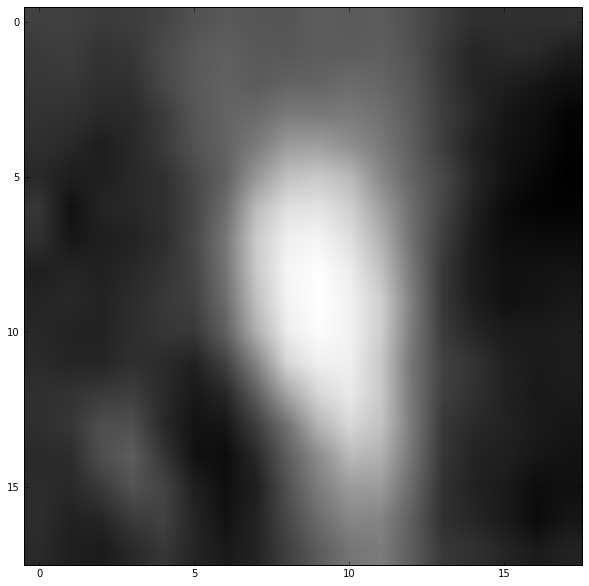

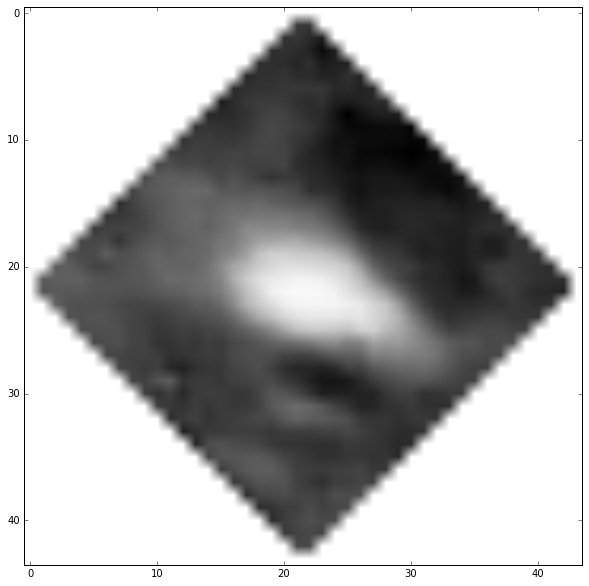

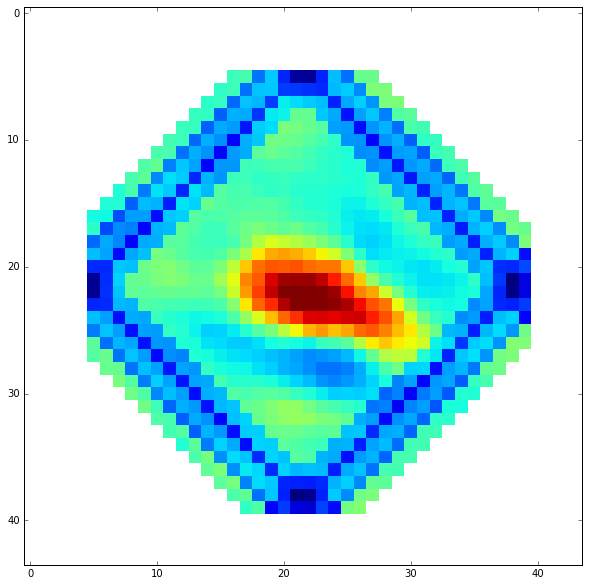

Image Location:  (22, 22)
Correlation at Image Location:  0.994950476316


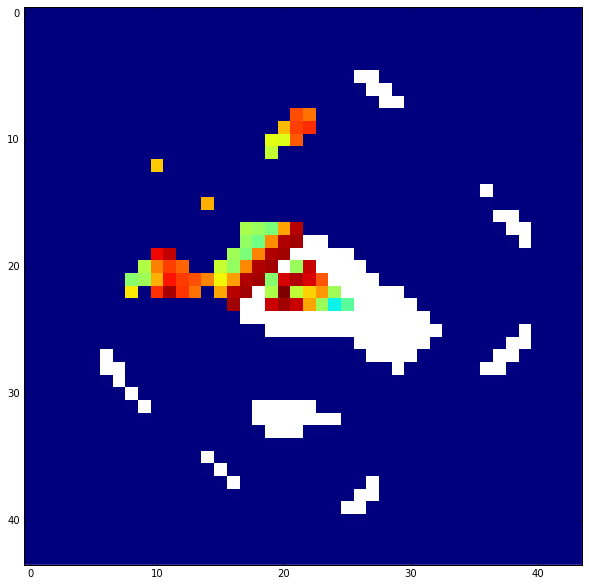

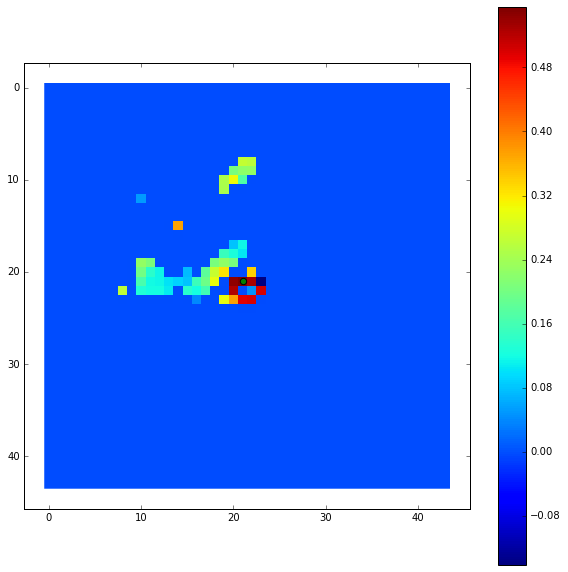

Correlation at Image Location: 
Maximum Correlation @  (21, 21)  with  0.555733880501
[ 0.26805604  0.26310224  0.20604468  0.22093169  0.22824752  0.24867283
  0.30569364  0.17039401  0.24623729  0.05305154  0.37105341  0.08041571
  0.11554857  0.15041276  0.12711157  0.10519855  0.22670516  0.20913963
  0.20710829  0.22597589  0.2069058   0.20143529  0.13888965  0.11488256
  0.07565057  0.18183084  0.27242497  0.32264612  0.33563326  0.16505175
  0.1195023   0.11503215  0.1026839   0.09257255  0.07994547  0.15549361
  0.19519145  0.30099155  0.54238823  0.55573388  0.52911172 -0.14122341
  0.26668818  0.13085742  0.12228361  0.12127601  0.10737884  0.13702065
  0.12201896  0.16077428  0.52527102  0.04744749  0.50352171  0.04115448
  0.30227597  0.37069493  0.49399543  0.50039134]


In [172]:
from scipy.ndimage.interpolation import zoom
from scipy.stats.stats import pearsonr 

figsize(10,10)
e = cg.edge[1][2]
matches = e.matches
clean_keys = ['subpixel']

full_offsets = np.zeros((len(matches), 3))

if clean_keys:
    matches, mask = e._clean(clean_keys)

# Preallocate the numpy array to avoid appending and type conversion
edge_offsets = np.empty((len(matches),3))

# for each edge, calculate this for each keypoint pair
for i, (idx, row) in enumerate(matches.iterrows()):
    s_idx = int(row['source_idx'])
    d_idx = int(row['destination_idx'])
    s_kps = e.source.get_keypoints().iloc[s_idx]
    d_kps = e.destination.get_keypoints().iloc[d_idx]

    s_keypoint = e.source.get_keypoints().iloc[s_idx][['x', 'y']].values
    d_keypoint = e.destination.get_keypoints().iloc[d_idx][['x', 'y']].values

    # Get the template and search windows
    s_template = sp.clip_roi(e.source.geodata, s_keypoint, 21)
    s_template = rotate(s_template, 0)
    s_template = imresize(s_template, .87)
    
    d_search = sp.clip_roi(e.destination.geodata, d_keypoint, 31)
    d_search = rotate(d_search, 45)
    d_search = imresize(d_search, 1.)
    
    imshow(s_template, cmap='Greys')
    show()
    imshow(d_search, cmap='Greys')
    show()
    
    ciratefi(s_template, d_search, upsampling=1, alpha=math.pi/4, cifi_thresh=90, rafi_thresh=70, use_percentile=True, radii=list(range(1,6)))
    break